# Spooky Author Identification <a class='tocSkip'>

By: [**Courtney Ferguson Lee**](https://www.linkedin.com/in/courtneyfergusonlee/)

<img src='https://raw.githubusercontent.com/spacecadet84/spooky_author_id/master/images/authors.png'>

# Introduction

This notebook tutorial will demonstrate how to use natural language processing to identify authors from text excerpts. It will also serve as my initial entry into Kaggle's natural language contest of the same name. The purpose is not to get to the top of the Kaggle leaderboard, but to help beginners develop their understanding of text learning. The authors include Edgar Allen Poe, HP Lovecraft and Mary Shelley. We'll start by exploring the structure of the data, then clean up any inconsistencies and create a few visualizations before feeding the data into our algorithm.

# Load Modules

There are a lot of libraries below, so it may be prudent to explain the purpose of a few of the major players. Pandas and Numpy will be used to manipulate our CSV files as necessary, while matplotlib and seaborn will be used to create visualizations so that we can better understand our data. The natural language processing modules will be used to reformat and manipulate our text data so that we can feed it into our machine learning models.

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', 200)
from IPython.display import display

# Visualizations
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
import seaborn as sns
sns.set_style('white')
colors = sns.color_palette()
import missingno as msno

# Misc
from time import time

# Natural Language Processing
import re
from google.cloud import language
from textblob import TextBlob as tb
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

# Machine Learning Models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

# Load Data

Our data is given to us in the form of two CSV files containing excerpts from each of the above 3 authors. We have a labeled dataset ("train.csv") which we will use to train our classifier and an unlabeled testing dataset aptly named "test.csv".

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

# Data Structure

Our training data is composed of 19,579 records and 3 variables: id, text and author. According to the contest page, the id column is a unique identifier for each sentence, which doesn't seem very useful right now. Assuming all exerpts were randomly selected, there shouldn't be any clear patterns from each exerpt's ID.

In [3]:
display(train_df.shape)
display(train_df.info())
display(train_df.describe())

(19579, 3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19579 entries, 0 to 19578
Data columns (total 3 columns):
id        19579 non-null object
text      19579 non-null object
author    19579 non-null object
dtypes: object(3)
memory usage: 459.0+ KB


None

,id,text,author
count,19579,19579,19579
unique,19579,19579,3
top,id07303,"I escaped from them to the room where lay the body of Elizabeth, my love, my wife, so lately living, so dear, so worthy.",EAP
freq,1,1,7900


# Feature Engineering

The unicode characters aren't playing nicely with tb. Let's convert them to ascii strings for now. We risk losing information in the form of special characters, but if that becomes an issue we'll come back to this later.

In [4]:
train_df.text = train_df.text.str.decode('utf-8', 'ignore')

## Stem Words

Our first step will be to convert our words into stem words. Stemming is the process of converting words into their root form. It may be helpful to go into detail here. For example, let's say we are trying identify whether an excerpt came from an MLA style guide or a baseball article and our classifier encountered the following words:

- formater
- formatted
- formats
- formatting

The above words would all be converted to their stem: format. "So what" you might say. "Why is this even useful?" The main advantage of stemming is that it condenses our featureset, which will help improve the accuracy of our classifier. As we will see further below, text classification involves sparse data, which actually hurts the accuracy of our models (more data is not always more helpful). By stemming our words beforehand, we can reduce the number of features two-fold or three-fold for English words and even more than that in other languages.

In [23]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [30]:
def get_lemmas(blob):
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word, pos in blob.tags:
        wordnet_pos = get_wordnet_pos(pos)
        if wordnet_pos:
            lemmas.append(lemmatizer.lemmatize(word, wordnet_pos))
        else: 
            lemmas.append(lemmatizer.lemmatize(word))
    return lemmas

In [33]:
def get_stems(words):
    stemmer = SnowballStemmer("english")
    stems = []
    if len(words)>0:
        for word in words:
            stems.append(stemmer.stem(word))
    return " ".join(stems)

In [35]:
train_df['text_blobs'] = train_df.text.apply(tb)
train_df['text_blob_words'] = train_df.text_blobs.apply(lambda x: (x.words))
train_df['lemmas'] = train_df.text_blobs.apply(get_lemmas)
train_df['lemma_stems'] = train_df.lemmas.apply(get_stems)
train_df['stems'] = train_df.text_blob_words.apply(get_stems)
train_df['words'] = train_df.text_blob_words.apply(lambda x: " ".join(list(x)))
train_df['word_count'] = train_df.text_blob_words.apply(len)

In [36]:
train_df.head()

,id,text,author,text_blobs,lemmas,lemma_stems,text_blob_words,stems,words,word_count
0,id26305,"This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so...",EAP,"(T, h, i, s, , p, r, o, c, e, s, s, ,, , h, o, w, e, v, e, r, ,, , a, f, f, o, r, d, e, d, , m, e, , n, o, , m, e, a, n, s, , o, f, , a, s, c, e, r, t, a, i, n, i, n, g, , t, h, e, , d, ...","[This, process, however, afford, me, no, mean, of, ascertain, the, dimension, of, my, dungeon, a, I, might, make, it, circuit, and, return, to, the, point, whence, I, set, out, without, be, aware,...",this process howev afford me no mean of ascertain the dimens of my dungeon a i might make it circuit and return to the point whenc i set out without be awar of the fact so perfect uniform seem the...,"[This, process, however, afforded, me, no, means, of, ascertaining, the, dimensions, of, my, dungeon, as, I, might, make, its, circuit, and, return, to, the, point, whence, I, set, out, without, b...",this process howev afford me no mean of ascertain the dimens of my dungeon as i might make it circuit and return to the point whenc i set out without be awar of the fact so perfect uniform seem th...,This process however afforded me no means of ascertaining the dimensions of my dungeon as I might make its circuit and return to the point whence I set out without being aware of the fact so perfe...,41
1,id17569,It never once occurred to me that the fumbling might be a mere mistake.,HPL,"(I, t, , n, e, v, e, r, , o, n, c, e, , o, c, c, u, r, r, e, d, , t, o, , m, e, , t, h, a, t, , t, h, e, , f, u, m, b, l, i, n, g, , m, i, g, h, t, , b, e, , a, , m, e, r, e, , m, i, ...","[It, never, once, occur, to, me, that, the, fumbling, might, be, a, mere, mistake]",it never onc occur to me that the fumbl might be a mere mistak,"[It, never, once, occurred, to, me, that, the, fumbling, might, be, a, mere, mistake]",it never onc occur to me that the fumbl might be a mere mistak,It never once occurred to me that the fumbling might be a mere mistake,14
2,id11008,"In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfact...",EAP,"(I, n, , h, i, s, , l, e, f, t, , h, a, n, d, , w, a, s, , a, , g, o, l, d, , s, n, u, f, f, , b, o, x, ,, , f, r, o, m, , w, h, i, c, h, ,, , a, s, , h, e, , c, a, p, e, r, e, d, , ...","[In, his, left, hand, be, a, gold, snuff, box, from, which, a, he, caper, down, the, hill, cut, all, manner, of, fantastic, step, he, take, snuff, incessantly, with, an, air, of, the, great, possi...",in his left hand be a gold snuff box from which a he caper down the hill cut all manner of fantast step he take snuff incess with an air of the great possibl self satisfact,"[In, his, left, hand, was, a, gold, snuff, box, from, which, as, he, capered, down, the, hill, cutting, all, manner, of, fantastic, steps, he, took, snuff, incessantly, with, an, air, of, the, gre...",in his left hand was a gold snuff box from which as he caper down the hill cut all manner of fantast step he took snuff incess with an air of the greatest possibl self satisfact,In his left hand was a gold snuff box from which as he capered down the hill cutting all manner of fantastic steps he took snuff incessantly with an air of the greatest possible self satisfaction,36
3,id27763,"How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering...",MWS,"(H, o, w, , l, o, v, e, l, y, , i, s, , s, p, r, i, n, g, , A, s, , w, e, , l, o, o, k, e, d, , f, r, o, m, , W, i, n, d, s, o, r, , T, e, r, r, a, c, e, , o, n, , t, h, e, , s, i, x, ...","[How, lovely, be, spring, As, we, look, from, Windsor, Terrace, on, the, sixteen, ferti

# Visualizations

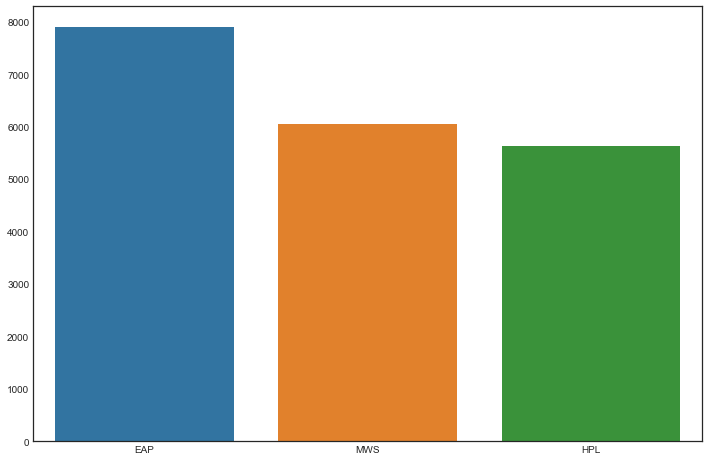

In [37]:
author_counts = train_df.author.value_counts()
sns.barplot(x=author_counts.index, y=author_counts.values)
plt.show()

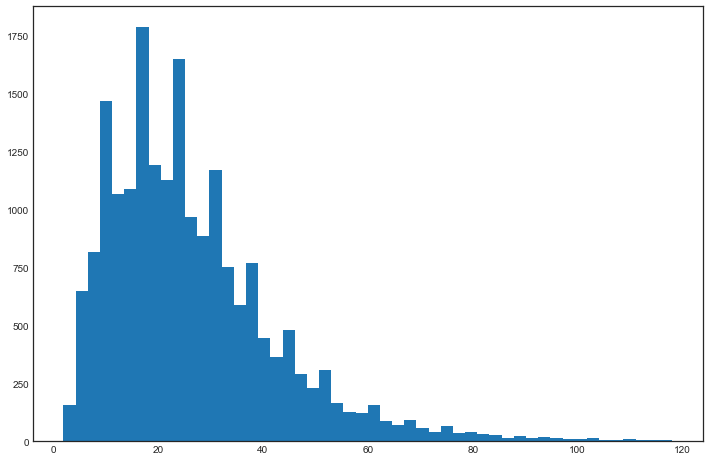

In [38]:
plt.hist(train_df[train_df.word_count<120].word_count, bins=50)
plt.show()

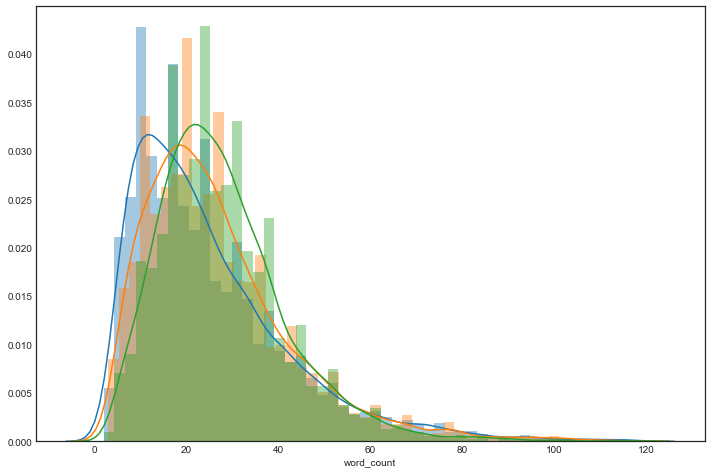

In [39]:
sns.distplot(
    train_df[(train_df.author=='EAP') & (train_df.word_count<120)].word_count,
    color=colors[0]
)
sns.distplot(
    train_df[(train_df.author=='MWS') & (train_df.word_count<120)].word_count,
    color=colors[1]
)
sns.distplot(
    train_df[(train_df.author=='HPL') & (train_df.word_count<120)].word_count,
    color=colors[2]
)
plt.show()

# Modeling

## Unigram Vectorization

### With Stemming

In [40]:
def vectorize(name, data):
    vectorizer = TfidfVectorizer()
    vectors = vectorizer.fit_transform(data)
    print "{0} Vector Shape: {1}".format(name, vectors.shape)
    return vectors

In [41]:
def get_scores(vectors, df):
    #x_train, x_test, y_train, y_test = train_test_split(vectors, df.author, test_size=.3, random_state=42)
    
    nb = MultinomialNB()
    svm = LinearSVC(random_state=42)
    logr = LogisticRegression(random_state=42)
    sgd = SGDClassifier(random_state=42)
    rf = RandomForestClassifier(random_state=42)

    classifiers = [
        ("Naive Bayes", nb), 
        ("Support Vector Machines", svm), 
        ("Logistic Regression", logr), 
        ("Stochastic Gradient Dissent", sgd), 
        ("Random Forests", rf)]

    scores = []

    for classifier in classifiers:
        name = classifier[0]
        clf = classifier[1]
        accuracies = cross_val_score(clf, vectors, df.author, cv=3)
        scores.append((name, np.mean(accuracies)))
        #clf.fit(x_train, y_train)
        #pred = clf.predict(x_test)
        #scores.append((name, accuracy_score(pred, y_test)))

    return scores


In [42]:
def plot_scores(scores):
    scores_df = pd.DataFrame(scores, columns=["name", "score"])
    scores_df.score *= 100
    plt.bar(range(len(scores_df.name)), scores_df.score, alpha=.7, color=colors[0])
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(range(len(scores_df.name)), scores_df.name)
    for x,y in zip(range(len(scores_df.name)), scores_df.score):
        plt.text(x, y, "{0:0.1f}".format(y), ha='center', va='bottom')
    plt.show()

Stem Vector Shape: (19579, 15130)


/Users/courtneyfergusonlee/anaconda/envs/DAND/lib/python2.7/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


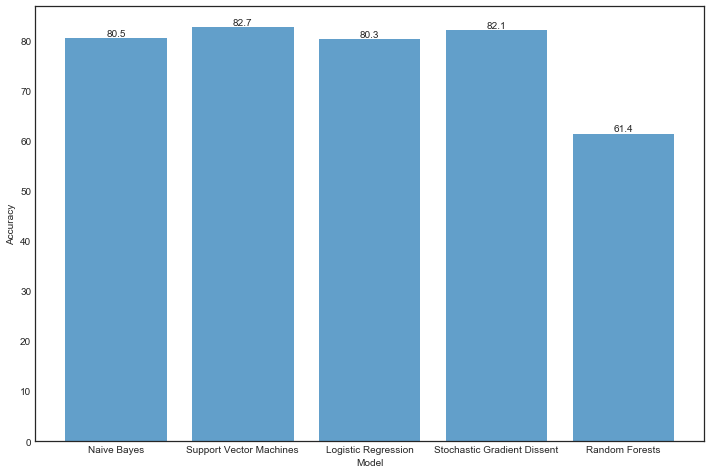

In [43]:
vectors = vectorize("Stem", train_df.stems)
scores = get_scores(vectors, train_df)
plot_scores(scores)

### Stemming and Lemmatization

Word Vector Shape: (19579, 14912)


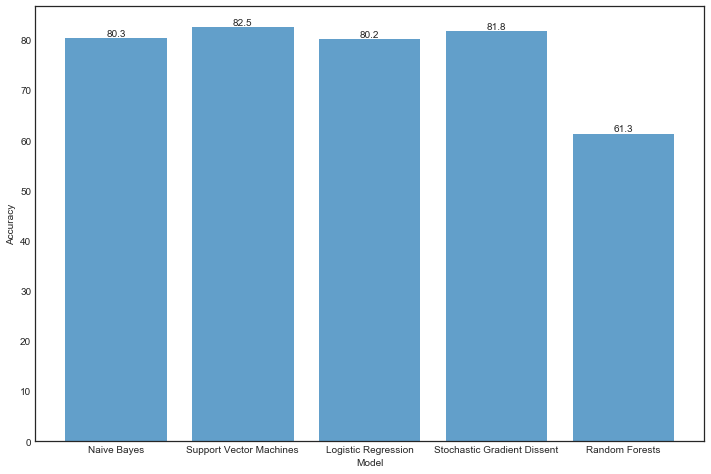

In [44]:
vectors = vectorize("Word", train_df.lemma_stems)
scores = get_scores(vectors, train_df)
plot_scores(scores)

### Without Stemming

Word Vector Shape: (19579, 25053)


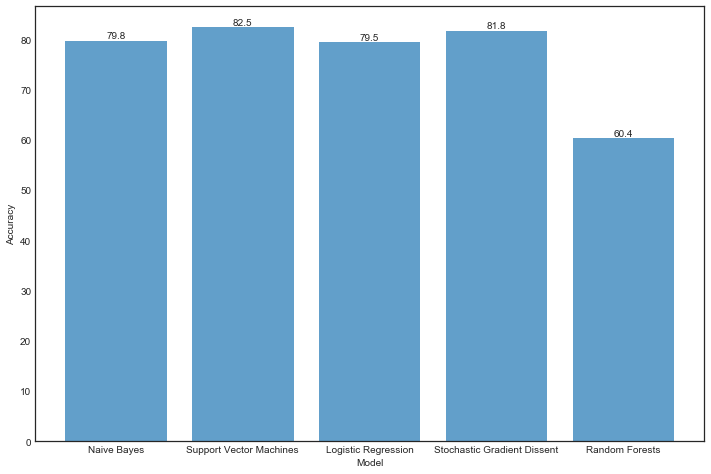

In [45]:
vectors = vectorize("Word", train_df.words)
scores = get_scores(vectors, train_df)
plot_scores(scores)

## Bigram Vectorization

### With Stemming

In [126]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5)
vectors = vectorizer.fit_transform(train_df.stems)
vectors.shape

(19579, 20467)

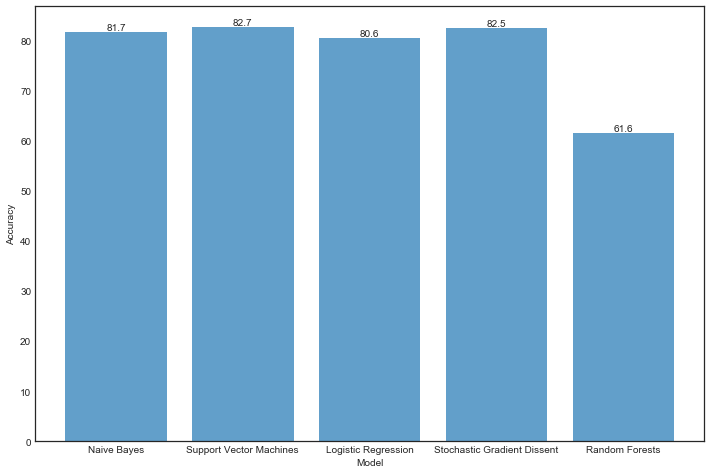

In [127]:
scores = get_scores(vectors, train_df)
plot_scores(scores)

### Without Stemming

In [128]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=5)
vectors = vectorizer.fit_transform(train_df.words)
vectors.shape

(19579, 21209)

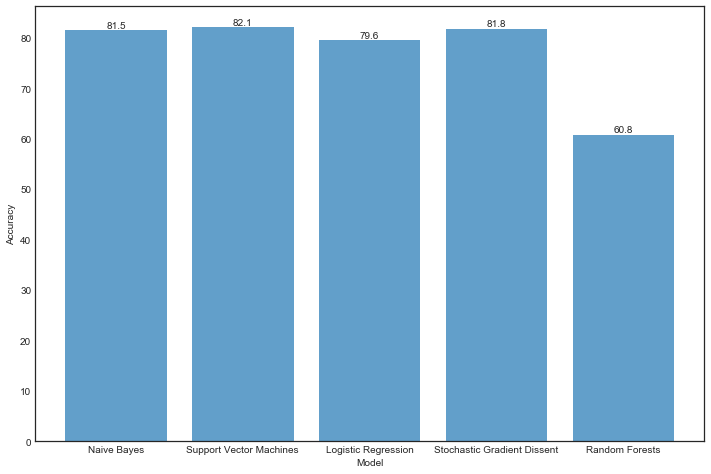

In [129]:
scores = get_scores(vectors, train_df)
plot_scores(scores)

## GridSearchCV for Multiple Parameters

In [ ]:
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                         ('tfidf', TfidfTransformer()),
                         ('clf-svm', SGDClassifier(loss='hinge', 
                                                   penalty='l2',
                                                   alpha=1e-3,
                                                   n_iter=5,
                                                   random_state=42)),

In [120]:


svm_steps = [
    ('vect', TfidfVectorizer(stop_words='english', min_df=5)),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())
]
         
clf_svm = Pipeline(svm_steps)

params_svm = {
    'vect__ngram_range': [(1,1), (1,2), (2,2)],
    'tfidf__use_idf': (True, False)
}

gs = GridSearchCV(clf_svm,
                  params_svm,
                  n_jobs = -1,
                  cv = 3,
                  scoring="accuracy",
                 )

print "Training Classifier"
t0 = time()

x_train, x_test, y_train, y_test = train_test_split(train_df.stems, train_df.author, test_size=.3, random_state=42)
gs = gs.fit(train_df.words, train_df.author)
print "done in {} seconds".format(time() - t0)

clf = gs.best_estimator_
print "Best estimator found by grid search:", clf
print "Best score found by grid search:", gs.best_score_

Training Classifier
done in 17.3230888844 seconds
Best estimator found by grid search: Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 1), norm=u'l2', preprocessor=None, smooth_idf=True...='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False))])
Best score found by grid search: 0.785688748149


In [123]:
nb_steps = [
    ('vect', TfidfVectorizer(stop_words='english', min_df=5)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
]

clf_nb = Pipeline(nb_steps)

params_nb = {
    'vect__ngram_range': [(1,3)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': [0.001, 0.01, 0.1, 1, 10, 100]
}

gs = GridSearchCV(clf_nb,
                  params_nb,
                  n_jobs = -1
                 )

print "Training Classifier"
t0 = time()

# x_train, x_test, y_train, y_test = train_test_split(train_df.stems, train_df.author, test_size=.3, random_state=42)
gs = gs.fit(train_df.stems, train_df.author)
print "done in {} seconds".format(time() - t0)

clf = gs.best_estimator_
print "Best estimator found by grid search:", clf
print "Best score found by grid search:", gs.best_score_

Training Classifier
done in 62.2866590023 seconds
Best estimator found by grid search: Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=5,
        ngram_range=(1, 3), norm=u'l2', preprocessor=None, smooth_idf=True...alse,
         use_idf=False)), ('clf', MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True))])
Best score found by grid search: 0.803616119312


In [57]:
train_df.loc[0,"stems"]

u'this process howev afford me no mean of ascertain the dimens of my dungeon as i might make it circuit and return to the point whenc i set out without be awar of the fact so perfect uniform seem the wall'

In [51]:
x_train.shape

(13705, 15130)

In [52]:
y_train.shape

(13705,)

# Conclusions

Overall, this was a great first step. The 83% accuracy achieved here is not phenomenal but it is a great baseline from which to improve and was accomplished in a few short lines of code! Next steps will include preparing this for submission and iterating on our process. Thanks for taking the time to read this!

#

#

#